In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Loading the Dataset

In [2]:
batch_size = 36
img_height = 224  
img_width = 224

In [3]:
image_dir = 'UECFOOD256'

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  labels='inferred', # each folder in image_dir would represent a class so setting this to 'inferred' would give 
  color_mode="rgb",
  label_mode ='categorical', # for class names that are not represented as numeric, also an alias to caterogical-cross entropy
  validation_split=0.2,
  subset="both",
  seed=666, # to produce consistent results 
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 26944 files belonging to 211 classes.
Using 21556 files for training.
Using 5388 files for validation.
Metal device set to: Apple M1 Pro


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Modelling
- First we instaniate the pretrained model that is going to be the backbone(base model) of our transfer learning task
- Next, we freeze the entire pretrained model so the weights of the base model are not updated when we trained on top of it. (Note that CNNs are trained from bottom to top)
    - First, we have to add some data augmentation to improve generalizability of our new model as our dataset size is small compared to the one that the pretrained model is trained on. 
    - Next, we send those into a preprocess layer that transform the data into inputs that are accepted into the pretrained model. 
    - Then, we double confirmed that the pretrained model is set to untrainable but passing in training = False
    - Next, the results are collected and averaged in the global average layer
    - Next, we introduced a dropout layer to randomly remove a portion of the 'connections' made from the penultimate to the final layer.
        - This artifically removes a portion of the model's training and is often used to reduce overfitting.
    - Then, the model outputs the predictions in the prediction layer. 
    - Finally, the model is complied and ready for training

In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=False, # For transfer-learning tasks, we don't want the final layer which is responsible for producing the actual classes
    weights="imagenet",
    input_shape=(224,224,3)
)

In [7]:
from tensorflow.keras import layers

pretrained_model.trainable = False # Important!
        
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(211, activation ='softmax')

#Being able to chain the transformations is one of Keras most useful feature of the Model API

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = pretrained_model(x, training=False) # Just to double confirm
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.9)(x) # High dropout rate 
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

# Training
- A relatively high base training rate is used to help bump accuracy
- We used an EarlyStopping Callback to help monitor the validation loss and stops the training when the validation loss is no longer improving for 3 epochs

In [8]:
base_learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    train_ds, 
    epochs=50, 
    validation_data=val_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights =True
        )
    ]
)

Epoch 1/50
599/599 [==============================] - 65s 106ms/step - loss: 6.3434 - accuracy: 0.0879 - val_loss: 2.7071 - val_accuracy: 0.3580
Epoch 2/50
599/599 [==============================] - 62s 104ms/step - loss: 4.1049 - accuracy: 0.2124 - val_loss: 2.1421 - val_accuracy: 0.4701
Epoch 3/50
599/599 [==============================] - 63s 105ms/step - loss: 3.5460 - accuracy: 0.2771 - val_loss: 1.9301 - val_accuracy: 0.5111
Epoch 4/50
599/599 [==============================] - 62s 104ms/step - loss: 3.3300 - accuracy: 0.3139 - val_loss: 1.8035 - val_accuracy: 0.5343
Epoch 5/50
599/599 [==============================] - 64s 107ms/step - loss: 3.2069 - accuracy: 0.3392 - val_loss: 1.7532 - val_accuracy: 0.5408
Epoch 6/50
599/599 [==============================] - 63s 105ms/step - loss: 3.1392 - accuracy: 0.3507 - val_loss: 1.7130 - val_accuracy: 0.5514
Epoch 7/50
599/599 [==============================] - 61s 102ms/step - loss: 3.0978 - accuracy: 0.3593 - val_loss: 1.6775 - val_ac

# Analysis of Training (Before Fine-Tuning)
- The scenario below shows signs of underfitting as both the validation and train curve do not show any signs of converging. 
    - This is likely due to the extremely high dropout rate that we set (0.9)
- This is undesirable as this means that the model is not learning properly
- Thus, we will fine tune it later to mitigate the underfitting. 

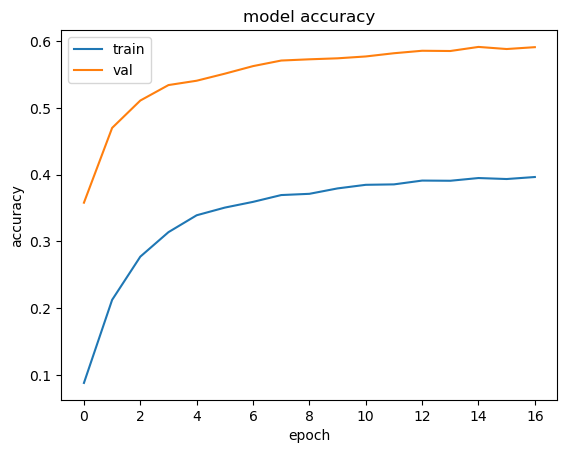

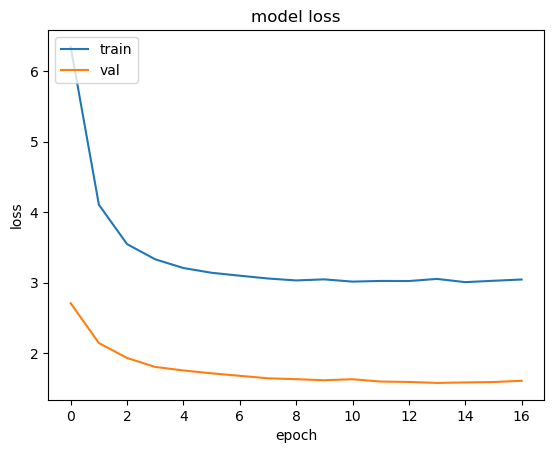

In [9]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Fine Tuning
- We first unfreeze the base model to allow the weights (params) of the pretrained model to be updatable with the current weights of the model
    - Yet, we don't want to completely retrain every single layer as well since the most bottom layers contain useful 'characteristics' of the pretrained model that are useful for general image recognition.
    - This is because the layers nearer to the top oftentimes contain 'characteristics' that are more specific to the dataset. (CNNs are trained from bottom to top) 
    - Thus, we will freeze the bottom layers of the pretrained model to ensure that we dont undo the training done for the pretrained model and unfreeze the upper layers and retrain them instead for our dataset.
- As for which layer is the 'optimal' layer to fine tune from, every dataset is different so there is no standard algorithm (not that we know of) and extensive trial and error is often employed 

In [10]:
pretrained_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                    

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate/100),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_fine = model.fit(train_ds, epochs=50, validation_data=val_ds, 
        callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights =True
        )
    ])

Epoch 1/50
599/599 [==============================] - 78s 127ms/step - loss: 2.5748 - accuracy: 0.3917 - val_loss: 1.6030 - val_accuracy: 0.5876
Epoch 2/50
599/599 [==============================] - 75s 125ms/step - loss: 2.4083 - accuracy: 0.4120 - val_loss: 1.5839 - val_accuracy: 0.5967
Epoch 3/50
599/599 [==============================] - 75s 125ms/step - loss: 2.3202 - accuracy: 0.4306 - val_loss: 1.5418 - val_accuracy: 0.5930
Epoch 4/50
599/599 [==============================] - 75s 125ms/step - loss: 2.2115 - accuracy: 0.4475 - val_loss: 1.4969 - val_accuracy: 0.6039
Epoch 5/50
599/599 [==============================] - 76s 127ms/step - loss: 2.1407 - accuracy: 0.4628 - val_loss: 1.5117 - val_accuracy: 0.6036
Epoch 6/50
599/599 [==============================] - 76s 126ms/step - loss: 2.0751 - accuracy: 0.4787 - val_loss: 1.4480 - val_accuracy: 0.6175
Epoch 7/50
599/599 [==============================] - 75s 126ms/step - loss: 2.0452 - accuracy: 0.4846 - val_loss: 1.4551 - val_ac

# Analysis of Training (After Fine-Tuning)
- The scenario below is good as they are neither overfitting nor underfitting.
    - Notice how even though the validationd curve sits completely above the train curve in the model accuracy graph, they are converging to a single point.
- Yet due to the severe underfitting just now, the final accuracy is not very high
    - This could be due to us stopping the model prematurely (we set the patience to 3 epochs).
- Hence, we decided to improvise and continue training the model for more epochs. 

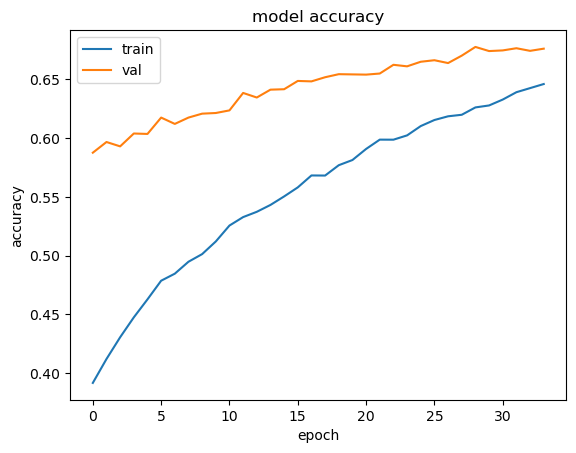

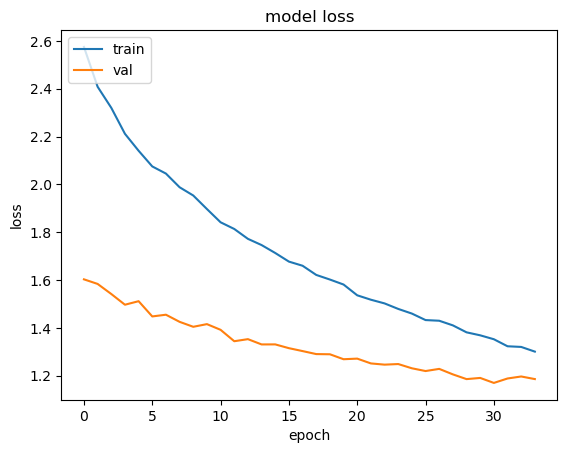

In [13]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Further Training


In [15]:
history_finer = model.fit(train_ds, epochs=50, validation_data=val_ds, 
        callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 3,
            restore_best_weights =True
        )
    ])

Epoch 1/50
599/599 [==============================] - 76s 127ms/step - loss: 1.3234 - accuracy: 0.6408 - val_loss: 1.1724 - val_accuracy: 0.6802
Epoch 2/50
599/599 [==============================] - 76s 126ms/step - loss: 1.3143 - accuracy: 0.6408 - val_loss: 1.1603 - val_accuracy: 0.6774
Epoch 3/50
599/599 [==============================] - 76s 127ms/step - loss: 1.2888 - accuracy: 0.6487 - val_loss: 1.1799 - val_accuracy: 0.6771
Epoch 4/50
599/599 [==============================] - 77s 129ms/step - loss: 1.2893 - accuracy: 0.6487 - val_loss: 1.1800 - val_accuracy: 0.6784
Epoch 5/50
599/599 [==============================] - 75s 126ms/step - loss: 1.2591 - accuracy: 0.6527 - val_loss: 1.1665 - val_accuracy: 0.6836


# Analysis of Training (After Fine-Tuning, Futher Training)
- Further training seems to be going past the point of diminishing return 


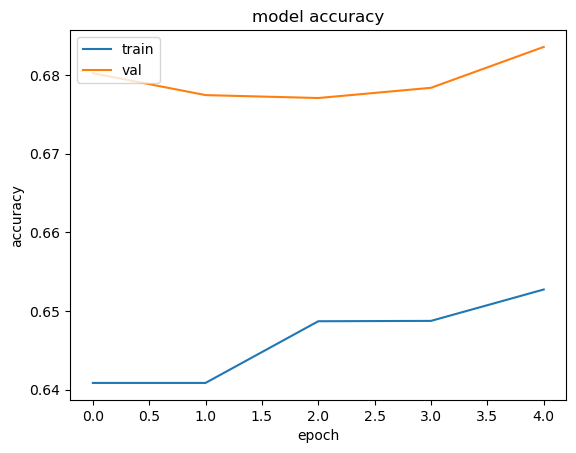

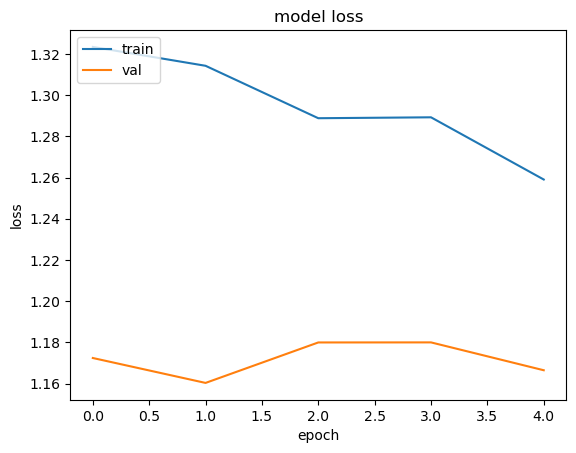

In [16]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_finer.history['accuracy'])
plt.plot(history_finer.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_finer.history['loss'])
plt.plot(history_finer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Learning Points/Area for improvements
For V2, underfitting is the main issue. Even though we 'rectified' it later on, the previous underfitting process stunted the model's growth.

Overall, there is two main areas of improvements, with the Dataset having the highest cost and highest value. 
A well labelled image datasets are not common. One that has sufficient size is even rarer. 
Thus, we will prioritize hyperparameter tweaking. 
- Hyperparameters(from highest to lowest value )
    - Dropout rate/Regularization
    - Base learning rate
    - Optimal layer for fine-tuning

- Dataset
    - Improve size and quality

# Saving Model

In [17]:
model.save('model_v2')

INFO:tensorflow:Assets written to: model_v2/assets


INFO:tensorflow:Assets written to: model_v2/assets
